<a href="https://colab.research.google.com/github/Alveuz/EquivalentImputation/blob/master/notebooks/EquivImpGFD_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------
# Install and Load Libraries

In [ ]:
install.packages('TOSTER')
install.packages('stringr')
install.packages('dplyr')
install.packages('reshape')

install.packages('ggplot2')
install.packages('ggridges')
install.packages('viridis')
install.packages('scales')
install.packages('latex2exp')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gridExtra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(TOSTER)
library(stringr)
library(dplyr)
library(reshape)

library(ggplot2)
library(ggridges)
library(viridis)
library(scales)
library(latex2exp)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal




--------
# Function to transform from PPM to Milliequivalents

In [ ]:
raw.2.mlEquivalent <- function(tmp_df)
{
  res_df <- tmp_df
  
  res_df$Na   <- tmp_df$Na/22.989770
  res_df$K    <- tmp_df$K/39.0983
  res_df$Mg   <- (tmp_df$Mg*2)/24.3050
  res_df$Ca   <- (tmp_df$Ca*2)/40.078
  res_df$Li   <- tmp_df$Li/6.941
  res_df$Cl   <- tmp_df$Cl/35.4527
  res_df$SO4  <- (tmp_df$SO4*2)/(32.066+(15.9994*4))
  res_df$HCO3 <- (tmp_df$HCO3)/(1.00794+12.0107+(15.9994*3))
  
  return(res_df)
}

----------
# Transform from PPM to MilliEquivalents

The original and imputed WCGDb must be in the working directory.
But first, we require to locate the original and the imputed datasets.

The original data namely `simplifiedWCGDb.csv` needs to be load in the main files section. The imputed datasets from the different imputation algorithms needs to be put into the folder `GFD_imputed_DB`.

## Original Data

In [ ]:
orig_csv_name = 'simplifiedWCGDb.csv'
original.data <- read.csv(orig_csv_name, header = T, stringsAsFactors = F)

drop_col <- c('X')#Id column

tmp_ixes <- !(colnames(original.data) %in% drop_col)
ft_names <- colnames(original.data)[tmp_ixes]

original.data <- original.data[,ft_names]
original.data <- raw.2.mlEquivalent(original.data)
head(original.data)

,Li,Na,K,Mg,Ca,Cl,SO4,HCO3,Temperature
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.003544158,12.55341,0.9079679,0.740588439,2.7346674,1.353917,5.6629150,9.158128,140
2,0.012908803,17.83402,1.0077164,0.460810615,1.2974699,1.833429,8.1737516,9.757962,162
3,0.017288575,29.57837,1.7903592,0.501954413,2.0959130,3.243759,0.7078644,NA,155
4,0.054747155,10.00445,0.1892665,0.008228842,1.7465941,NA,NA,NA,95
5,0.060510013,22.00979,1.4067108,0.403209298,0.5788712,2.256528,9.8060035,NA,163
6,0.060510013,23.14073,1.5857467,0.477268134,0.3193772,2.256528,9.4937104,NA,160


## Imputed Data

In [ ]:
imp_path<- 'GFD_Imputed_DB/'

files_ls <- list.files(imp_path)
imp_dfs <- list()

for(i in 1:length(files_ls))
{
  # print(files_ls[i])
  imp_dfs[[i]] <- read.csv(paste0(imp_path,files_ls[i]), header = T)
  imp_dfs[[i]]['Temperature'] <- original.data$Temperature
  imp_dfs[[i]] <- imp_dfs[[i]][,ft_names]
  imp_dfs[[i]] <- raw.2.mlEquivalent(imp_dfs[[i]])
}

### Renaming imputed datasets by the name of the algorithm

In [ ]:
imp_file_names <- strsplit(files_ls, '_')
imp_names <- sapply(1:length(imp_file_names), 
                    function(i) imp_file_names[[i]][2])
names(imp_dfs) <- imp_names

In [ ]:
na_col_ixes <- sapply(1:dim(original.data)[2], 
                      function(i) any(is.na(original.data[,i])))

ckc4eqv.ft <- colnames(original.data)[na_col_ixes]

EqvlntImp.df <- data.frame(expand.grid(imp_names,ckc4eqv.ft))
colnames(EqvlntImp.df) <- c('algorithm', 'imputed.var')

EqvlntImp.df <- EqvlntImp.df %>% 
                mutate(algorithm.parsed = recode_factor(algorithm, 
                                                        'dt514a' = "DT^-", 
                                                        'dt514b' = "DT^*", 
                                                        'dt522' = "miDT^*", 
                                                        'knn' = "KNN^-",
                                                        'mean' = "mu",
                                                        'median' = "median",
                                                        'mice' = "MICE^-",
                                                        'rf522' = "RF^*",
                                                        'stocLR' = "StochLR",
                                                        'svrl514a' = "SVR_l^-", 
                                                        'svrl514b' = "SVR_l^*", 
                                                        'svrl522' = "miSVR_l^*",
                                                        'svrr514a' = "SVR_r^-", 
                                                        'svrr514b' = "SVR_r^*", 
                                                        'svrr522' = "miSVR_r^*"
                                                        ))

EqvlntImp.df$algorithm <- as.character(EqvlntImp.df$algorithm)
EqvlntImp.df$imputed.var <- as.character(EqvlntImp.df$imputed.var)

EqvlntImp.df$min.Eq.val <- 0.99
EqvlntImp.df$p.ttest    <- 0.001
EqvlntImp.df$p.tost     <- 0.99
EqvlntImp.df$has.eqvlnc <- F

In [ ]:
for(j in 1:dim(EqvlntImp.df)[1])
{
  tmp_df  <- imp_dfs[[EqvlntImp.df$algorithm[j]]]
  tmp_ft  <- EqvlntImp.df$imputed.var[j]
  ft_orig <- original.data[,tmp_ft]
  ft_imp  <- tmp_df[,tmp_ft]
  
  d <- seq(0.0001, 0.99, by = 0.025)
  df_tost <- data.frame()
  for (i in 1:length(d)) 
  {
    
    m1 <- mean(ft_orig,na.rm = T)
    m2 <- mean(ft_imp)
    
    sd1 <- sd(ft_orig,na.rm = T)
    sd2 <- ifelse(sd(ft_imp)==0,0.000000001,sd(ft_imp))
    
    n1 <- length(na.omit(ft_orig))
    n2 <- length(ft_imp)
    
    low_eqbound_d  <- -d[i]
    high_eqbound_d <- d[i]
    
    alpha <- 0.05
    
    tost.test <- TOSTtwo(m1, m2, 
                         sd1, sd2, 
                         n1, n2, 
                         low_eqbound_d, high_eqbound_d, 
                         alpha,
                         var.equal = F, plot = F, verbose = F)
    
    sdpooled <- sqrt((sd1^2 + sd2^2)/2)
    low_eqbound <- low_eqbound_d * sdpooled
    high_eqbound <- high_eqbound_d * sdpooled
    degree_f <- (sd1^2/n1 + sd2^2/n2)^2/(((sd1^2/n1)^2/(n1 - 
                                                          1)) + ((sd2^2/n2)^2/(n2 - 1)))
    t1 <- ((m1 - m2) - low_eqbound)/sqrt(sd1^2/n1 + sd2^2/n2)
    p1 <- pt(t1, degree_f, lower.tail = FALSE)
    t2 <- ((m1 - m2) - high_eqbound)/sqrt(sd1^2/n1 + sd2^2/n2)
    p2 <- pt(t2, degree_f, lower.tail = TRUE)
    t <- (m1 - m2)/sqrt(sd1^2/n1 + sd2^2/n2)
    pttest <- 2 * pt(-abs(t), df = degree_f)
    ptost <- max(p1, p2)
    
    df_tost <- rbind(df_tost, data.frame(tost.test))
    if(pttest > alpha && ptost <= alpha) 
    {
      EqvlntImp.df$min.Eq.val[j] <- d[i]
      EqvlntImp.df$p.ttest[j]    <- pttest
      EqvlntImp.df$p.tost[j]     <- ptost
      
      na_ix   <- is.na(ft_orig)
      EqvlntImp.df$has.eqvlnc[j] <- T

      break
    }
  }
}

------------
# Minimun Equivalence Interval

# A tibble: 66 × 7
# Groups:   imputed.var [6]
   algorithm imputed.var algorithm.parsed min.Eq.val p.ttest p.tost has.eqvlnc
   <chr>     <chr>       <fct>                 <dbl>   <dbl>  <dbl> <lgl>     
 1 dt514b    Li          DT^*                  0.275  0.0741 0.0468 TRUE      
 2 knn       Li          KNN^-                 0.275  0.0807 0.0400 TRUE      
 3 mice      Li          MICE^-                0.150  0.839  0.0327 TRUE      
 4 svrr514b  Li          SVR_r^*               0.225  0.270  0.0292 TRUE      
 5 svrr522   Li          miSVR_r^*             0.150  0.644  0.0494 TRUE      
 6 dt514a    Mg          DT^-                  0.125  0.597  0.0436 TRUE      
 7 dt514b    Mg          DT^*                  0.125  0.561  0.0477 TRUE      
 8 dt522     Mg          miDT^*                0.150  0.517  0.0208 TRUE      
 9 knn       Mg          KNN^-                 0.150  0.529  0.0199 TRUE      
10 mean      Mg          mu                    0.150  0.503  0.0219 TRUE      
# … w

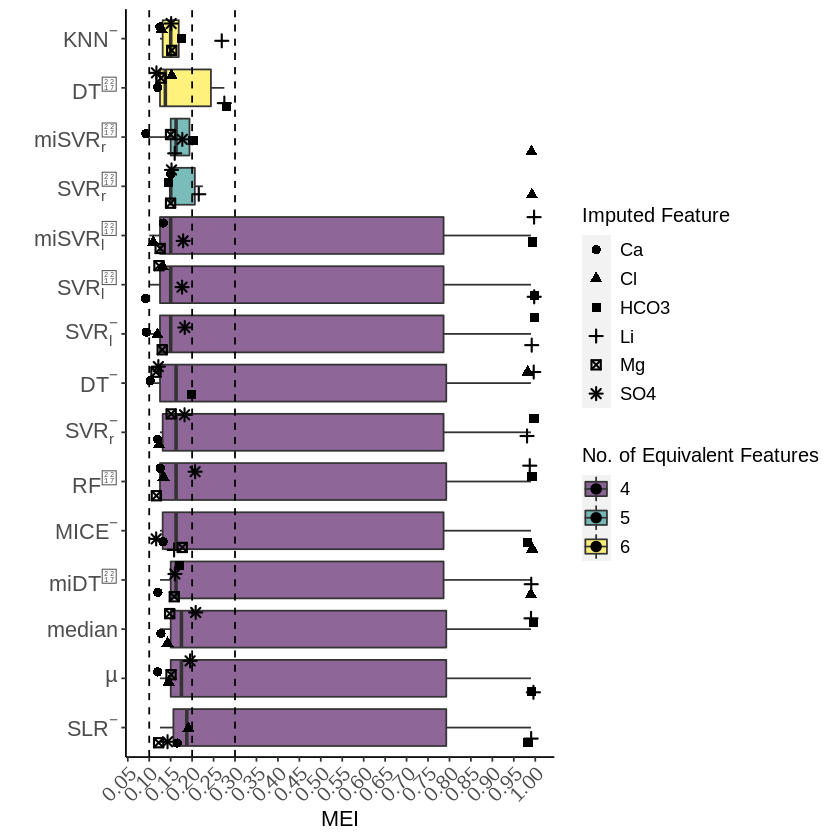

In [ ]:
res <- EqvlntImp.df %>% #group_by(algorithm) %>%
                        group_by(imputed.var) %>% filter(min.Eq.val<=0.3)

print(res)

tmp1 <- EqvlntImp.df %>% 
                    group_by(algorithm) %>% 
                    mutate(No.Feats.Equivalent = length(algorithm[min.Eq.val<=0.3]))
tmp1$No.Feats.Equivalent <- as.factor(tmp1$No.Feats.Equivalent)

tmp.lim <- c('dt514a','dt514b','dt522','knn','mean','median','mice',
             'rf522','stocLR','svrl514a','svrl514b','svrl522',
             'svrr514a','svrr514b','svrr522')
tmp.lbs <- c('dt514a' = parse(text= TeX("$DT^{-}$")),
             'dt514b' = parse(text = TeX("$DT^{*}$")),
             "dt522" = parse(text = TeX("$miDT^{*}$")),
             'knn' = parse(text = TeX("$KNN^{-}$")),
             'mean' = parse(text = TeX("$\\mu$")), 
             "median" = parse(text = TeX("$median$")),
             "mice" = parse(text = TeX("$MICE^{-}$")), 
             'rf522' = parse(text = TeX("$RF^{*}$")),
             "stocLR" = parse(text = TeX("$SLR^{-}$")), 
             "svrl514a" = parse(text = TeX("$SVR_l^{-}$")), 
             "svrl514b" = parse(text = TeX("SVR_l^{*}")), 
             "svrl522" = parse(text = TeX("$miSVR_l^{*}$")), 
             "svrr514a" = parse(text = TeX("$SVR_r^{-}$")), 
             "svrr514b" = parse(text = TeX("SVR_r^{*}")), 
             "svrr522" = parse(text = TeX("$miSVR_r^{*}$")))

# png(paste0(savef.path,"mei_plot.png"), width=1800, height=1000, res = 160)
ggplot(tmp1, aes(x=reorder(algorithm, -min.Eq.val, FUN = mean), y=min.Eq.val, fill=No.Feats.Equivalent))+
  geom_boxplot(outlier.shape = NA)+
  geom_jitter(aes(shape = imputed.var), color="black", size=2, stroke = .9 )+
  scale_x_discrete(breaks=tmp.lim, labels = tmp.lbs)+
  scale_y_continuous(breaks = seq(0, 1,by=0.05))+
  coord_flip()+
  scale_fill_viridis(discrete = T, alpha=0.6, option="D")+
  theme(axis.line.x = element_line(size = 0.5, linetype = "solid",
                                   colour = "black"),
        axis.line.y = element_line(size = 0.5, linetype = "solid",
                                   colour = "black"),
        axis.text.x = element_text(size = 12,angle=45,hjust=1),
        axis.text.y = element_text(size = 13),
        axis.title.x = element_text(size = 13),
        axis.title.y = element_text(size = 13),
        legend.text = element_text(size = 11),
        legend.title = element_text(size = 12),
        panel.background = element_rect(fill='white', color='white'))+
  geom_hline(yintercept = 0.1, linetype="dashed", color = "black", size=0.5)+
  geom_hline(yintercept = 0.2, linetype="dashed", color = "black", size=0.5)+
  geom_hline(yintercept = 0.3, linetype="dashed", color = "black", size=0.5)+
  labs(fill = "No. of Equivalent Features", shape = 'Imputed Feature')+
  xlab('')+ylab('MEI')

## Ridgeline plots of original vs Imputed dataset
In order to appreciate the imputation quality carried out by the different 
imputation algorithms, the density distribution function of the original WCGDb 
against the datasets obtained by the imputation algorithms is shown.

Using  as id variables

Picking joint bandwidth of 0.259

Warning message:
“Removed 452 rows containing non-finite values (stat_density_ridges).”
Using  as id variables

Picking joint bandwidth of 0.59

Warning message:
“Removed 114 rows containing non-finite values (stat_density_ridges).”
Using  as id variables



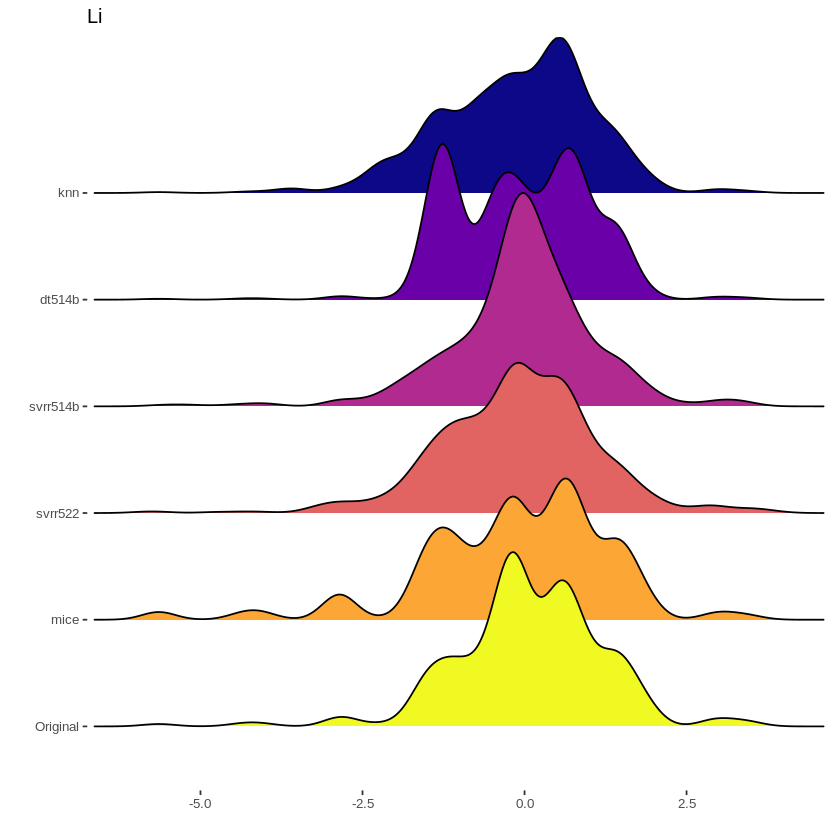

Picking joint bandwidth of 0.684

Warning message:
“Removed 44 rows containing non-finite values (stat_density_ridges).”
Using  as id variables



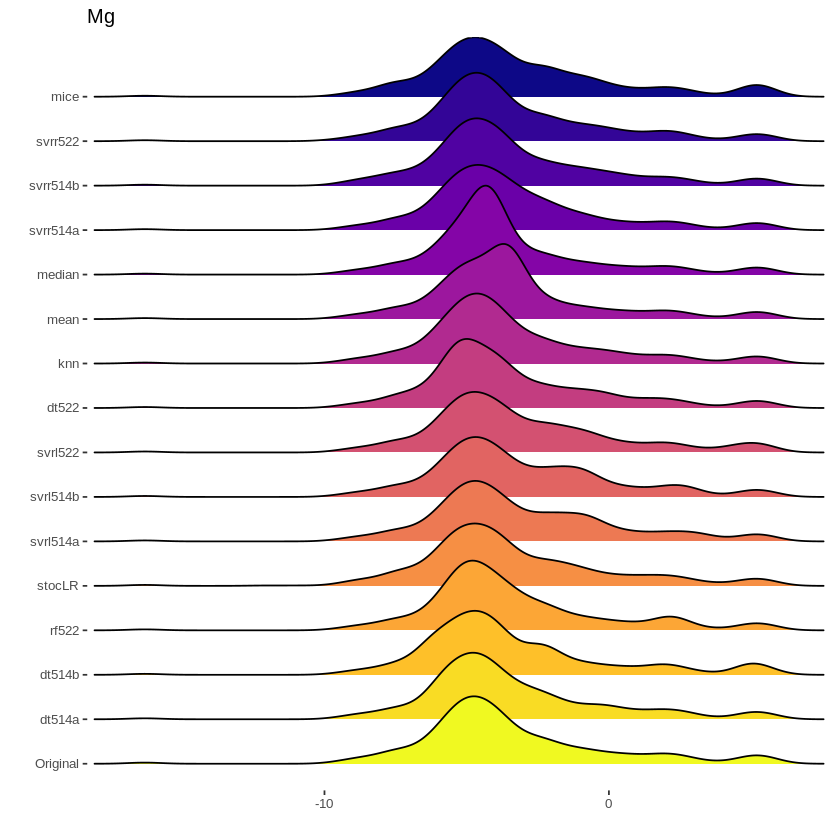

Picking joint bandwidth of 0.484

Warning message:
“Removed 157 rows containing non-finite values (stat_density_ridges).”
Using  as id variables



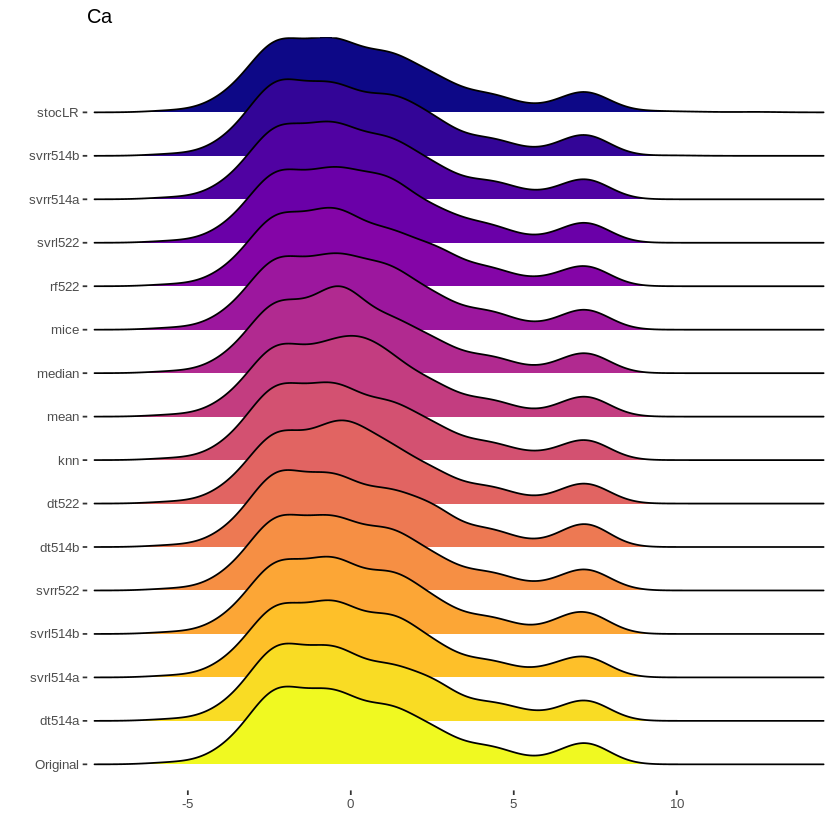

Picking joint bandwidth of 0.255

Warning message:
“Removed 191 rows containing non-finite values (stat_density_ridges).”
Using  as id variables



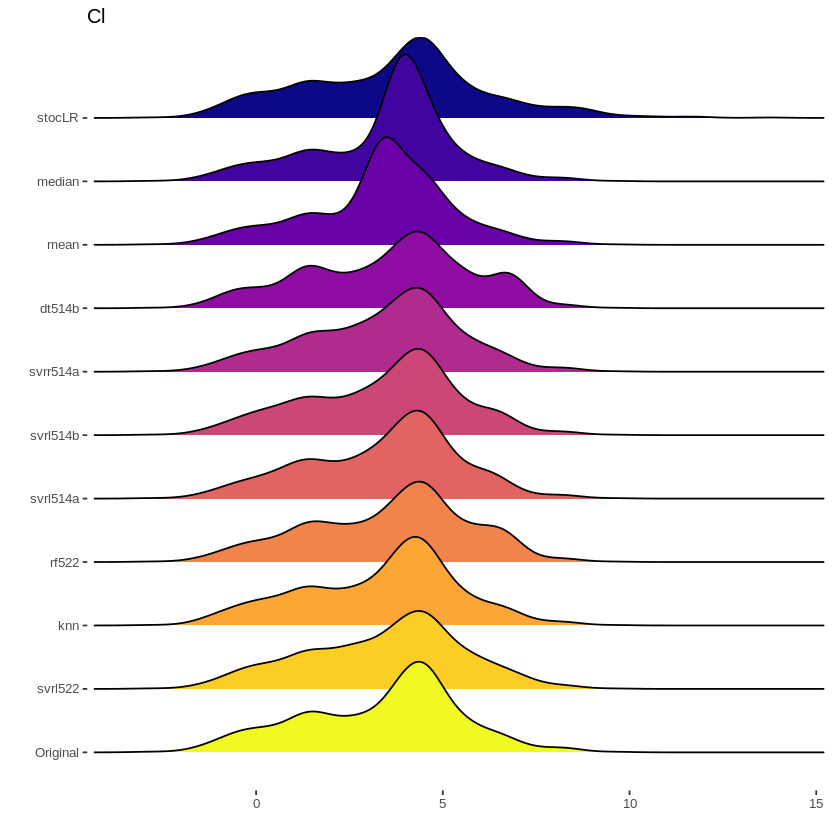

Picking joint bandwidth of 0.375

Warning message:
“Removed 412 rows containing non-finite values (stat_density_ridges).”


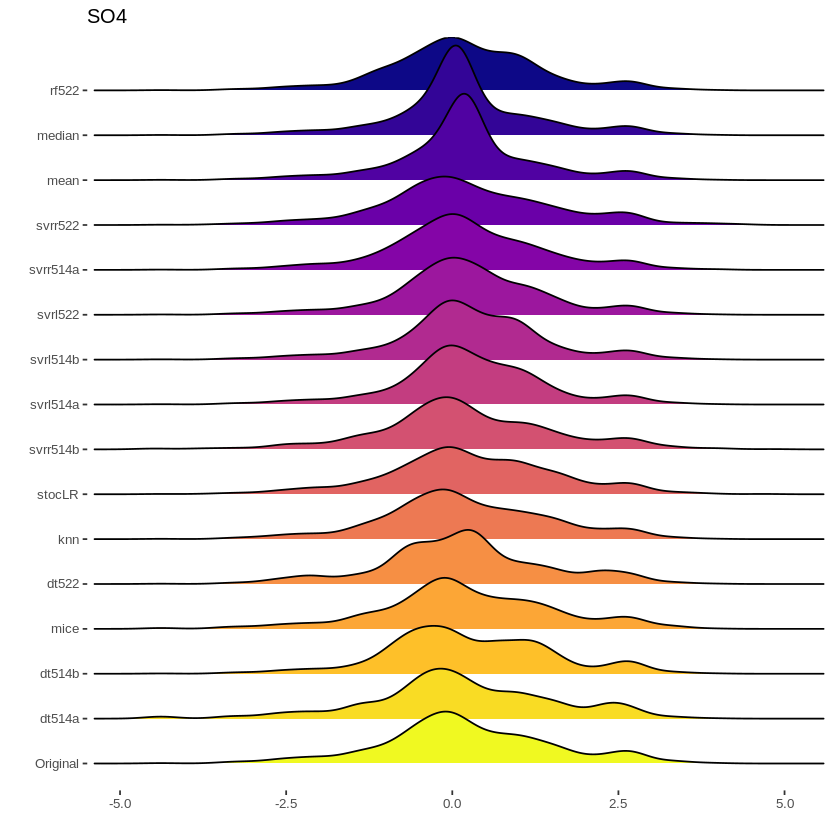

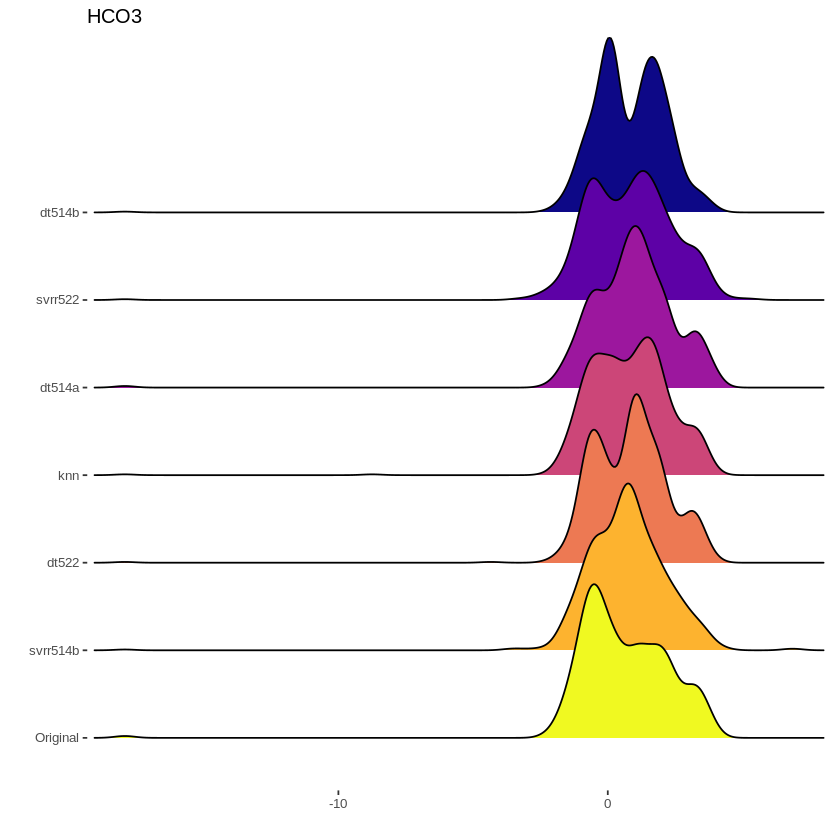

In [ ]:
for(i in ckc4eqv.ft)
{
  ridge_df  <- data.frame(log(original.data[,i]))
  colnames(ridge_df) <- 'Original'
  achiev_eq <- EqvlntImp.df %>% filter(imputed.var==i & has.eqvlnc == T)
  achiev_eq <- achiev_eq[order(achiev_eq$min.Eq.val, decreasing = F),]
  
  for(k in 1:dim(achiev_eq)[1])
  {
    ridge_df <- cbind(ridge_df,
                      data.frame(log(imp_dfs[[achiev_eq$algorithm[k]]][,i])))
  }
  
  colnames(ridge_df)[2:dim(ridge_df)[2]] <- achiev_eq$algorithm
  
  ridge_mtl <- melt(ridge_df)
  
  plot(
  ggplot(ridge_mtl, aes(x = value, y = variable, fill = variable)) + 
    geom_density_ridges(scale = 2)+
    # scale_y_discrete(expand = c(0.01, 0)) +
    scale_x_continuous(expand = c(0.01, 0)) +
    scale_fill_viridis(name = 'Imputation Alg.', discrete=TRUE, option = 'C',direction = -1)+
    theme(legend.position = "none", panel.background = element_blank(), 
          text = element_text(size=10)) + labs(x="", y="" )+
    labs(title = i)
  )

}

# Charge Balance Error Analysis

Using  as id variables

Using  as id variables



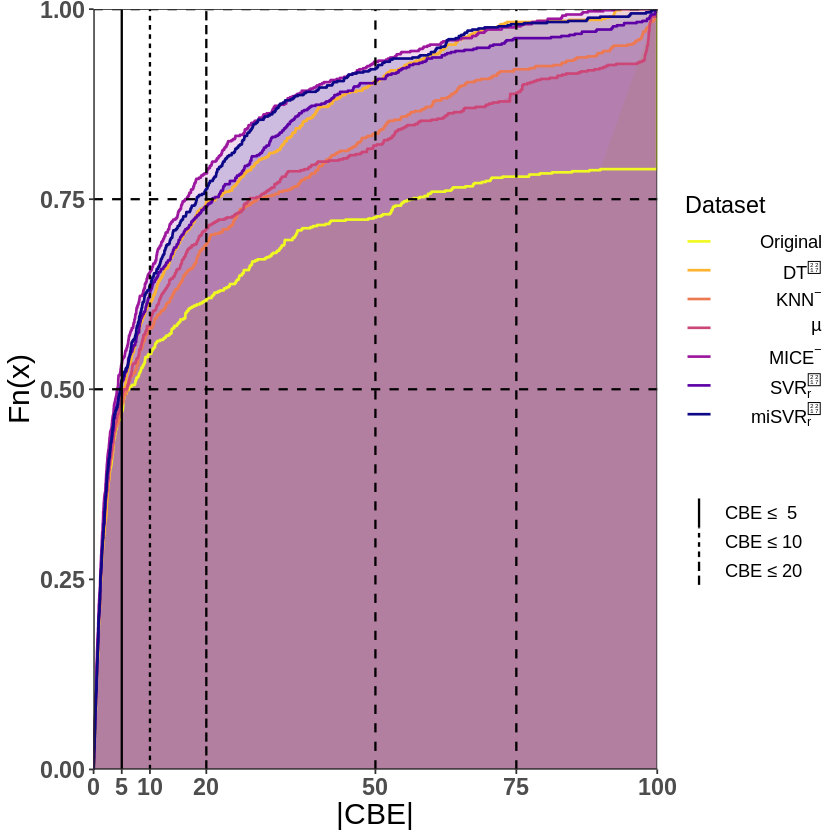

In [ ]:
cbe_df <- data.frame(matrix(nrow=dim(original.data)[1],ncol=(length(imp_names)+1)))
colnames(cbe_df) <- c('original',imp_names)

cation_list <- c('Li', 'Ca', 'Mg', 'K', 'Na')
anion_list <- c('Cl', 'SO4', 'HCO3')

for(j in colnames(cbe_df))
{
  if(j=='original')
  {
    cation_sum <- rowSums(original.data[cation_list], na.rm=T)
    anion_sum  <- rowSums(original.data[anion_list], na.rm=T)
  }else{
    tempsy <- imp_dfs[[j]]
    cation_sum <- rowSums(tempsy[cation_list], na.rm=T)
    anion_sum  <- rowSums(tempsy[anion_list], na.rm=T)
  }
  CBE <- abs(((cation_sum-anion_sum)/(cation_sum+anion_sum))*100)
  cbe_df[,j] <- CBE
}

cbe_lim5 <- 5
cbe_lim10<- 10
cbe_lim20<- 20

ddata <- data.frame(cbind(cbe_lim5,cbe_lim10,cbe_lim20))
ddata.m <- melt(ddata)
colnames(ddata.m)[1] <- 'upper.lim'
ddata.m$upper.lim <- c('CBE \u2264  5', 'CBE \u2264 10', 'CBE \u2264 20')

cbe_mtl <- melt(cbe_df)
# cbe_metl1 <- cbe_mtl
cbe_metl1 <- filter(cbe_mtl, variable =='original' | variable =='knn' | variable =='dt514b' | variable =='svrr522' | variable == 'svrr514b' | variable == 'mice' | variable == 'mean')

tmp.lbs <- c('original'= 'Original', 
             'dt514a' = parse(text= TeX("$DT^{-}$")),
             'dt514b' = parse(text = TeX("$DT^{*}$")),
             "dt522" = parse(text = TeX("$miDT^{*}$")),
             'knn' = parse(text = TeX("$KNN^{-}$")),
             'mean' = parse(text = TeX("$\\mu$")), 
             "median" = parse(text = TeX("$median$")),
             "mice" = parse(text = TeX("$MICE^{-}$")), 
             'rf522' = parse(text = TeX("$RF^{*}$")),
             "stocLR" = parse(text = TeX("$SLR^{-}$")), 
             "svrl514a" = parse(text = TeX("$SVR_l^{-}$")), 
             "svrl514b" = parse(text = TeX("SVR_l^{*}")), 
             "svrl522" = parse(text = TeX("$miSVR_l^{*}$")), 
             "svrr514a" = parse(text = TeX("$SVR_r^{-}$")), 
             "svrr514b" = parse(text = TeX("SVR_r^{*}")), 
             "svrr522" = parse(text = TeX("$miSVR_r^{*}$")))

plot(
  ggplot(cbe_metl1, aes(value, color = variable, fill = variable)) +
  stat_ecdf(geom = "area",alpha = 0.15, color = NA) +
  stat_ecdf(alpha=1,geom="step", size = 0.75)+
  geom_vline(data=ddata.m,
             aes(xintercept = value,linetype=upper.lim),
             size=0.65) +
  geom_hline(yintercept = 0, linetype="solid", color = "black", size=0.5) +
  geom_hline(yintercept = 0.5, linetype="dashed", color = "black", size=0.65) +
  geom_hline(yintercept = 0.75, linetype="dashed", color = "black", size=0.65) +
  geom_hline(yintercept = 1, linetype="dashed", color = "black", size=0.65) +
  geom_vline(xintercept = 0, linetype="solid", color = "black", size=0.5) +
  geom_vline(xintercept = 50, linetype="dashed", color = "black", size=0.65) +
  geom_vline(xintercept = 75, linetype="dashed", color = "black", size=0.65) +
  scale_color_viridis(discrete = T, alpha=0.6, option="C",labels = tmp.lbs,direction = -1)+
  scale_fill_viridis(discrete = T, alpha=0.6, option="C",guide = 'none',direction = -1)+
  labs(color = 'Dataset',
       linetype = '',
       y = "Fn(x)", 
       x="|CBE|")+
  theme_bw()+
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.text.x = element_text(face="bold", size=14),
        axis.text.y = element_text(face="bold", size=14),
        axis.title.x = element_text(size=18),
        axis.title.y = element_text(size=18),
        legend.title = element_text(size=14),
        legend.text = element_text(size=11),
        panel.background = element_rect(fill='white', color='white',colour = 'white'))+
  scale_x_continuous(limits=c(0, 100), expand = c(0, 0), breaks=c(0,5,10,20,50,75,100))+
  scale_y_continuous(limits=c(0, 1), expand = c(0, 0))
)